In [1]:
import logging
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import qmc
from tqdm import tqdm
import random

In [2]:
logging.config.fileConfig('ESDatalogging.ini')
logger = logging.getLogger('jsonLogger')

In [3]:
# Read the data
df = pd.read_csv('Data/cobol_pullrequests.csv', usecols= ['login','name'])

# Add user (u: ) repo (r: ) indicator for each node
df['login'] = df['login'].apply(lambda x: 'u: '+x)
df['name']  = df['name'].apply(lambda x: 'r: '+x)

# List user and repos
users = df['login'].unique().tolist()
repos = df['name'].unique().tolist()

#Rename columns
df = df.rename(columns={"login":"source","name":"target"})

# Display
df

,source,target
0,u: vim-sroberge,r: vimaec/g3d
1,u: vim-sroberge,r: vimaec/g3d
2,u: vim-sroberge,r: vimaec/g3d
3,u: vim-sroberge,r: vimaec/g3d
4,u: mavimaec,r: vimaec/g3d
...,...,...
1328,u: joe-tingsanchali-sonarsource,r: SonarSource/sonar-scanning-examples
1329,u: joe-tingsanchali-sonarsource,r: SonarSource/sonar-scanning-examples
1330,u: joe-tingsanchali-sonarsource,r: SonarSource/sonar-scanning-examples
1331,u: joe-tingsanchali-sonarsource,r: SonarSource/sonar-scanning-examples


In [7]:
def user_user_similarity(adj_matrix, repos):
    
    # Evaluate user-user similarity:
    
    ## Get repo - user similarity (upper-right square):
    repo_user = adj_matrix.iloc[:len(repos),len(repos):]
    repo_user = repo_user/np.linalg.norm(repo_user,axis=0,keepdims=True)
    repo_user[np.isnan(repo_user)] = 0
    repo_user = np.dot(repo_user.transpose(),repo_user)

    ## Get user - repo similarity (lower-left square):
    user_repo = adj_matrix.iloc[len(repos):,:len(repos)]
    user_repo = user_repo/np.linalg.norm(user_repo,axis=1,keepdims=True)
    user_repo[np.isnan(user_repo)] = 0
    user_repo = np.dot(user_repo, user_repo.transpose())

    # Combine upper and lower triangles, keep 0 in the diagonal.
    user_user = np.triu(repo_user,1) + np.tril(user_repo,-1)

    return user_user


def create_adjacency_matrix(edge_list):
    
    # Build the adjacency matrix for user - repo (and repo - user) interactions.
    
    adj_matrix = pd.crosstab(edge_list['source'], edge_list['target']).astype(float)
    idx = adj_matrix.columns.union(adj_matrix.index)
    adj_matrix = adj_matrix.reindex(index = idx, columns=idx, fill_value=0.0) 
    adj_matrix.loc[users, users] = user_user_similarity(adj_matrix, repos)
    
    return adj_matrix

# Mutator, given an edge_list, and it will return the mutated edge_list.

def mutate(edge_list, node, repos):

    # Create copy of edge_lis:
    el = edge_list.copy()

    
    # Create 1 to 10 random new edges and add them to the edge list.
    add = random.randint(1, 10)

    for i in range(add): 
        new_edge_user_repo = pd.DataFrame({'source':[node], 'target':[random.choice(repos)]})
        el = pd.concat([el, new_edge_user_repo], ignore_index=True, axis=0)
    
    
    # Else, delete 1 to 5 edges if random == 0 with 25% prob.
    if np.random.choice([0,1], p=[0.25,0.75]) == 0:
        remove = np.random.choice([1,2,3,4,5])
        
        aux_el = None
        # Check that removing edges dont remove users or repos.
        while aux_el is None or not len(aux_el['source'].unique()) == len(users) or not len(aux_el['target'].unique()) == len(repos):
        
            drop_idxs = np.random.choice(el.index, remove, replace=False)
            aux_el = el.drop(drop_idxs).reset_index(drop=True)
        
        el = aux_el

    return el


def graph_metrics(edge_list):
    
    # Evaluate Degree and Eigenvector centralities for each node in a Graph
    G = nx.from_pandas_adjacency(create_adjacency_matrix(edge_list), create_using=nx.DiGraph)
    
    result = pd.DataFrame({'Centrality': nx.pagerank(G), 'Degree': {node:val for (node, val) in G.degree()}})

    # filter users
    result = result[result.index.str.startswith('u: ')]
    
    # Scale values
    for column in result:
        result[column] = result[column].apply(lambda x: (x - result[column].min())/(result[column].max() - result[column].min()))

    return result


def objective(candidate):  
    # Evaluate metrics in terms of star-discrepancy
    return qmc.discrepancy(candidate, method='L2-star',workers=-1)


In [8]:
def es_plus(edge_list, users, repos, objective, n_iter, mu, lam):
    
    best, best_eval = None, 1e+10
    
    # calculate the number of children per parent
    n_children = int(lam / mu)
    
    # initial population
    population = list()
  
    for i in range(lam):
        candidate = edge_list.copy()            # copy the initial edge_list
        population.append(candidate)            # add to population

    # perform the search
    for epoch in range(n_iter):
        # evaluate the fitness for the population
        scores = [objective(graph_metrics(candidate)) for candidate in population]
        # rank scores in ascending order
        ranks = np.argsort(np.argsort(scores))
        # select the indexes for the top mu ranked solutions, drop the worse results
        selected = [i for i,_ in enumerate(ranks) if ranks[i] < mu]
        # create offspring from parents
        offspring = list()
        for i in selected:
        # check if this parent is the best solution ever seen
            if scores[i] < best_eval:
                best, best_eval, niter = population[i], scores[i], epoch
                logger.info('%d, Score: %.5f' % (epoch, best_eval))
        
            # keep the parent
            offspring.append(population[i])

            # create offspring for parent
            for j in range(n_children):
                sample = np.random.choice(users)
                child = mutate(population[i], sample, repos)
                offspring.append(child)

        # replace population with children
        population = offspring
  
    return niter, best, best_eval

In [9]:
n_iter, mu, lam = 1000, 1, 20
niter, best, best_eval = es_plus(df, users, repos, objective,n_iter, mu, lam)

09/23/2022 03:25:32 AM - INFO, Iteration:0, Score: 0.53291
09/23/2022 03:25:33 AM - INFO, Iteration:1, Score: 0.51912
09/23/2022 03:25:33 AM - INFO, Iteration:2, Score: 0.50843
09/23/2022 03:25:34 AM - INFO, Iteration:3, Score: 0.49801
09/23/2022 03:25:35 AM - INFO, Iteration:4, Score: 0.48962
09/23/2022 03:25:36 AM - INFO, Iteration:5, Score: 0.47867
09/23/2022 03:25:37 AM - INFO, Iteration:6, Score: 0.46840
09/23/2022 03:25:38 AM - INFO, Iteration:7, Score: 0.45827
09/23/2022 03:25:39 AM - INFO, Iteration:8, Score: 0.45159
09/23/2022 03:25:40 AM - INFO, Iteration:9, Score: 0.43968
09/23/2022 03:25:41 AM - INFO, Iteration:10, Score: 0.43368
09/23/2022 03:25:41 AM - INFO, Iteration:11, Score: 0.42862
09/23/2022 03:25:43 AM - INFO, Iteration:12, Score: 0.41973
09/23/2022 03:25:44 AM - INFO, Iteration:13, Score: 0.41353
09/23/2022 03:25:44 AM - INFO, Iteration:14, Score: 0.40675
09/23/2022 03:25:45 AM - INFO, Iteration:15, Score: 0.39993
09/23/2022 03:25:46 AM - INFO, Iteration:16, Score

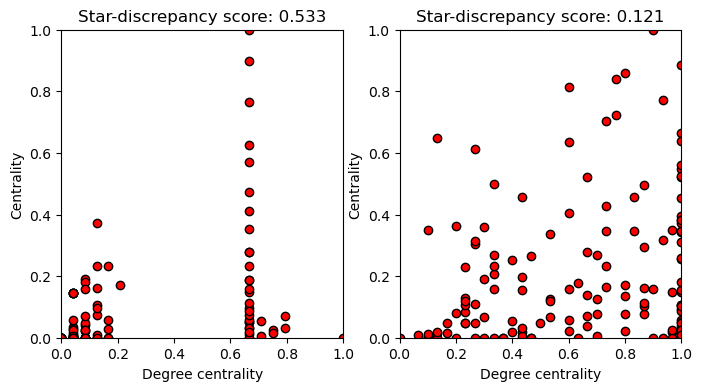

In [10]:
def draw_plot(ax, data):
    
    ax = ax or plt.gca()
    
    ax.scatter(data['Degree'], data['Centrality'], edgecolor='k', c='r')
    ax.set_xlabel('Degree centrality')
    ax.set_ylabel('Centrality')
    ax.set_title(f'Star-discrepancy score: {objective(data):.3f}')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    plt.close()
    
    return ax


fig, (ax1,ax2) = plt.subplots(1,2, figsize=(8,4))
ax1 = draw_plot(ax1, graph_metrics(df))
ax2 = draw_plot(ax2, graph_metrics(best))
plt.close()

fig

In [11]:
best

,source,target
0,u: vim-sroberge,r: vimaec/g3d
1,u: vim-sroberge,r: vimaec/g3d
2,u: vim-sroberge,r: vimaec/g3d
3,u: vim-sroberge,r: vimaec/g3d
4,u: mavimaec,r: vimaec/g3d
...,...,...
1678,u: raisjn,r: flaechsig/cobolj
1679,u: jbyibm,r: IBM/zOS-Client-Web-Enablement-Toolkit
1680,u: AlbGarciam,r: RuchikaL11/sonar_try
1681,u: shalom938,r: AkinJimoh/aj-soner


In [12]:
[x for x in best['source'] if x.startswith('r: ')]

[]

In [13]:
[x for x in best['target'] if x.startswith('u: ')]

[]

In [14]:
best.to_csv('Data/evolved_dataset.csv', index=False)